In [55]:
import os
import numpy as np
import matplotlib.pyplot as plt
import maglab

import torch
import torch.nn.functional as F

### 1.Load the geometry of the nanodisk

In [2]:
geo = np.load("dataset/geo.npy")
nx, ny, nz = geo.shape
print(geo.shape)
maglab.display.show(geo[:,ny//2, :])

dx = 1.835e-9

(82, 82, 60)


### 2.Load the phasemap data

In [124]:
phaseset = maglab.dataset.PhaseSet()
for i in range(8):
    phasemap = torch.load(f"dataset/phasemap_{i}.pth")
    phaseset.load(phasemap)
print(phaseset[0].data.shape)
phaseset.sort()

torch.Size([120, 120])


(<Figure size 2000x1000 with 16 Axes>,
 array([[<Axes: title={'center': '(-65.0, 0.0, 0.0)'}>,
         <Axes: title={'center': '(-61.0, 0.0, 0.0)'}>,
         <Axes: title={'center': '(-58.0, 0.0, 0.0)'}>,
         <Axes: title={'center': '(-54.0, 0.0, 0.0)'}>],
        [<Axes: title={'center': '(-50.0, 0.0, 0.0)'}>,
         <Axes: title={'center': '(-44.0, 0.0, 0.0)'}>,
         <Axes: title={'center': '(-28.0, 0.0, 0.0)'}>,
         <Axes: title={'center': '(-0.0, 0.0, 0.0)'}>]], dtype=object))

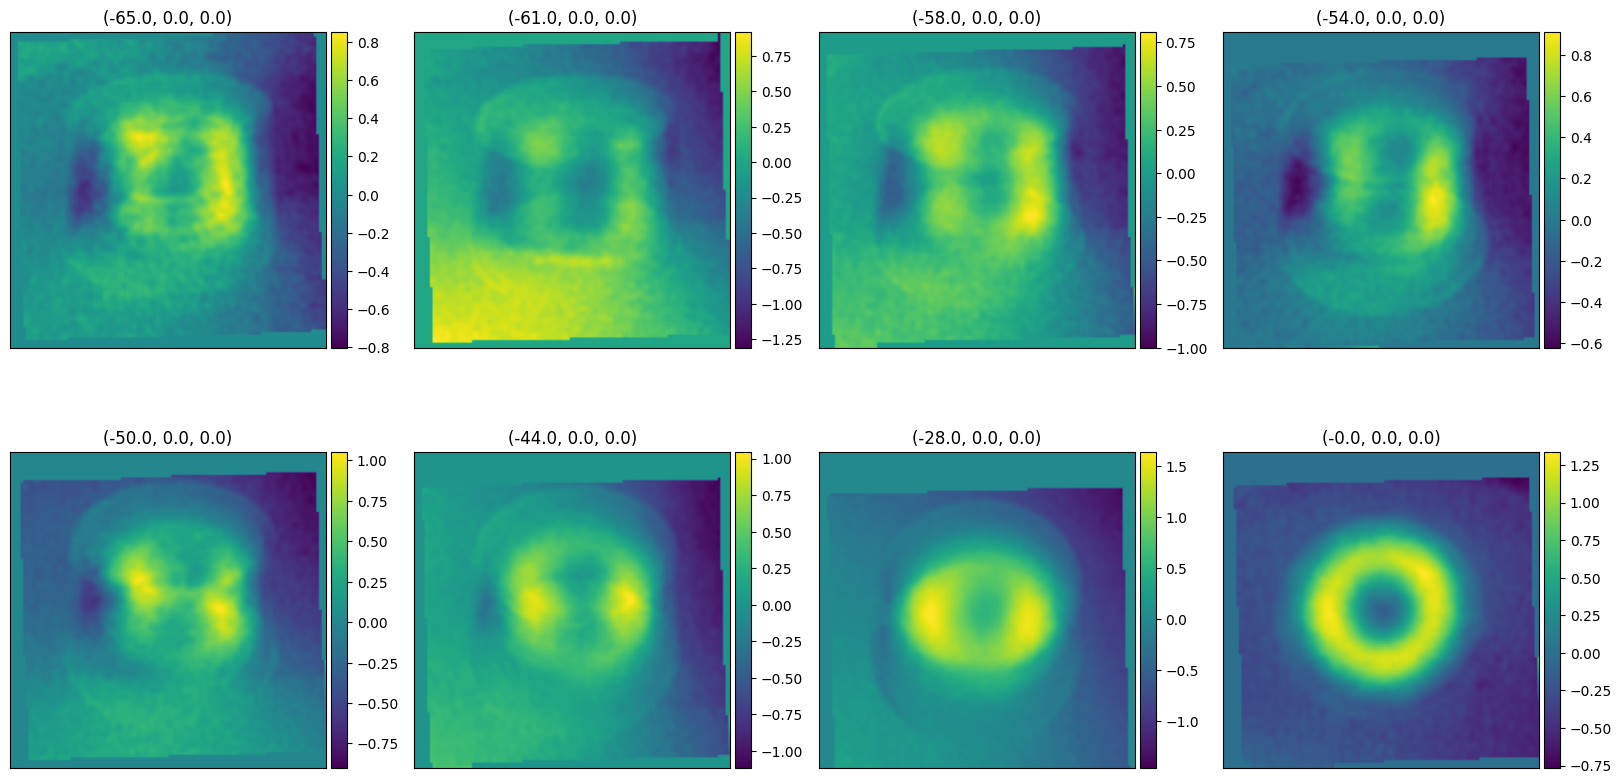

In [125]:
maglab.display.show_list([x.data.numpy() for x in phaseset], 
                         titles=[x.Euler for x in phaseset], 
                         same_colorbar=False,  rows=2,)

### 3.Initialize micro, optimizer, and phasemapper

In [126]:
Ms = 3.84e5
A = 8.78e-12
D = 1.58e-3
micro = maglab.Micro(nx,ny,nz,dx)
micro.set_Ms(geo*3.84e5)
micro.add_exch(A)
micro.add_dmi(D)
micro.cuda()

Micro(
  (interactions): ModuleList(
    (0): Exch()
    (1): DMI()
  )
)

In [127]:
def m0_fun():
    x, y = np.arange(nx), np.arange(ny)
    X, Y = np.meshgrid(x,y,indexing='ij')
    xc,yc = nx//2, ny//2
    R = np.sqrt((X-xc)**2 + (Y-yc)**2)
    m0 = np.zeros((3,nx,ny,nz))
    m0[2,] = 1.
    mask = (R > 15) & (R < 30)
    m0[2,mask, :] = -1
    return m0

micro.init_m0(m0_fun())

In [128]:
sd = maglab.SteepestDescent(micro.shape).cuda()
phasemapper = maglab.PhaseMapper(120, dx, rotation_padding=120).cuda()

### 4.Start optimize

In [129]:
# we need to compare the phase shift after removal of low-frequency signal, 
# so we apply a gauss kernel filter on the images.
gauss_kernel_size = 99
sigma = maglab.preprocess.compute_sigma(gauss_kernel_size)
kernel = maglab.preprocess.gaussian_kernel(gauss_kernel_size, sigma)
kernel_groups = kernel.repeat(8, 1, 1, 1).cuda()

In [130]:
os.makedirs("pngs", exist_ok=True)

In [131]:
phi_input = torch.stack([phasemap.data for phasemap in phaseset]).cuda()
mask = torch.stack([phasemap.mask for phasemap in phaseset]).cuda()
Eulers = [phasemap.Euler for phasemap in phaseset]

epoch: 0
epoch: 100
epoch: 200
epoch: 300
epoch: 400
epoch: 500
epoch: 600
epoch: 700
epoch: 800
epoch: 900
epoch: 1000
epoch: 1100
epoch: 1200
epoch: 1300
epoch: 1400
epoch: 1500
epoch: 1600
epoch: 1700
epoch: 1800
epoch: 1900
epoch: 2000


f:\python package\maglab\maglab\display.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(rows, columns, figsize=figsize)


epoch: 2100
epoch: 2200
epoch: 2300
epoch: 2400
epoch: 2500
epoch: 2600
epoch: 2700
epoch: 2800
epoch: 2900


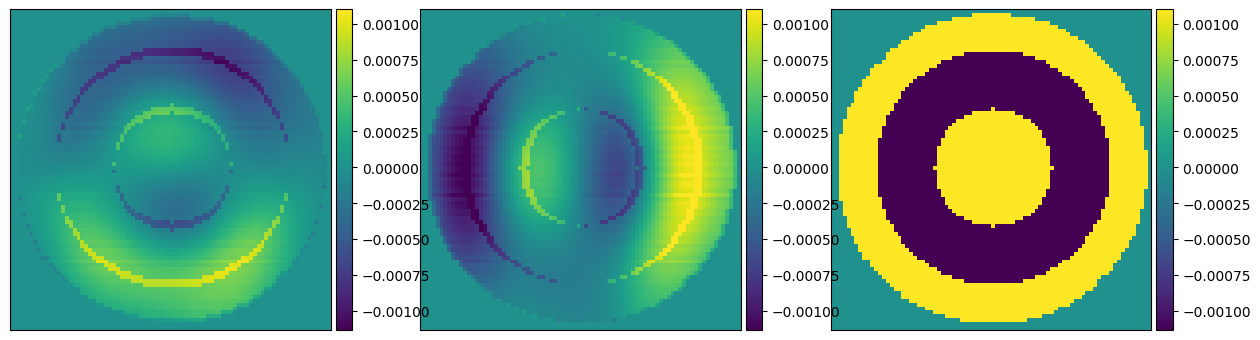

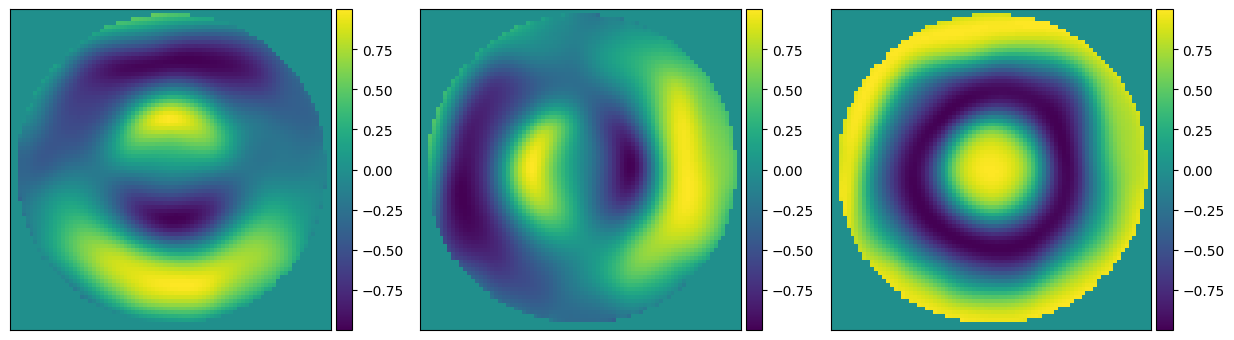

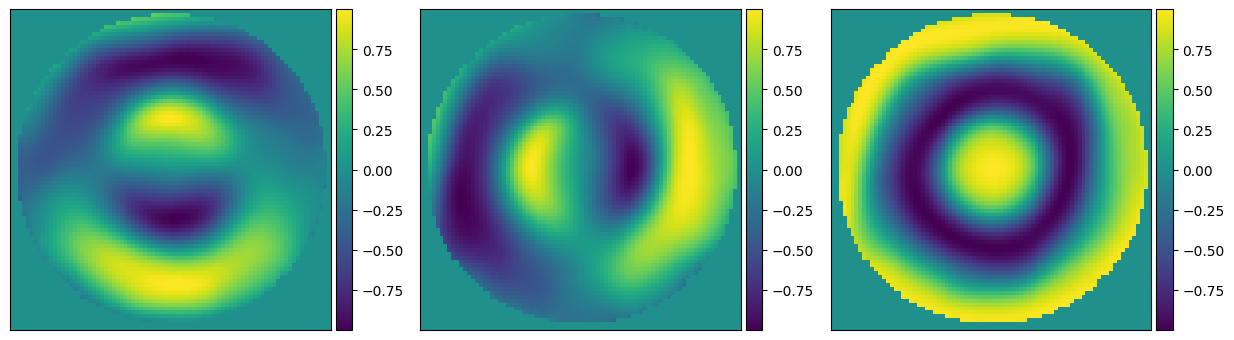

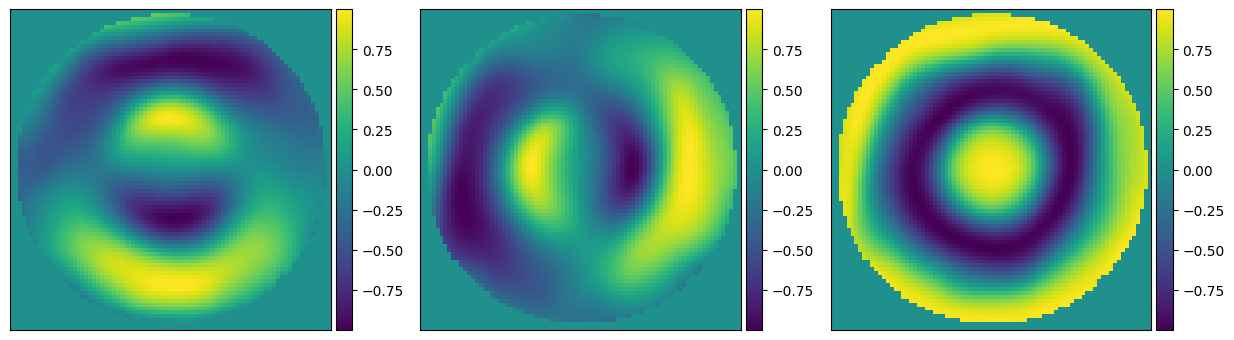

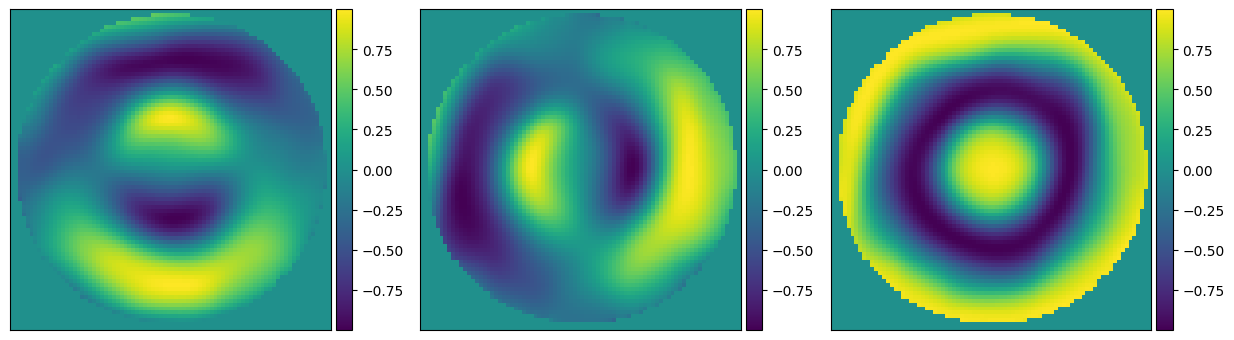

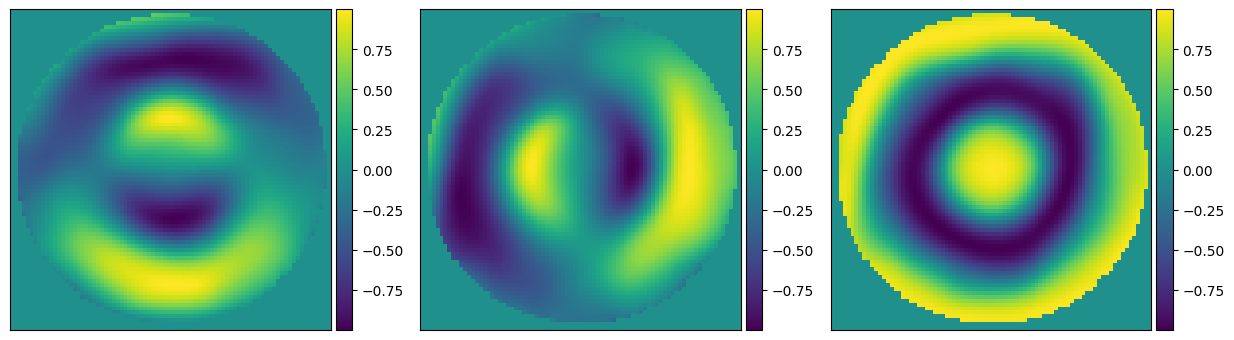

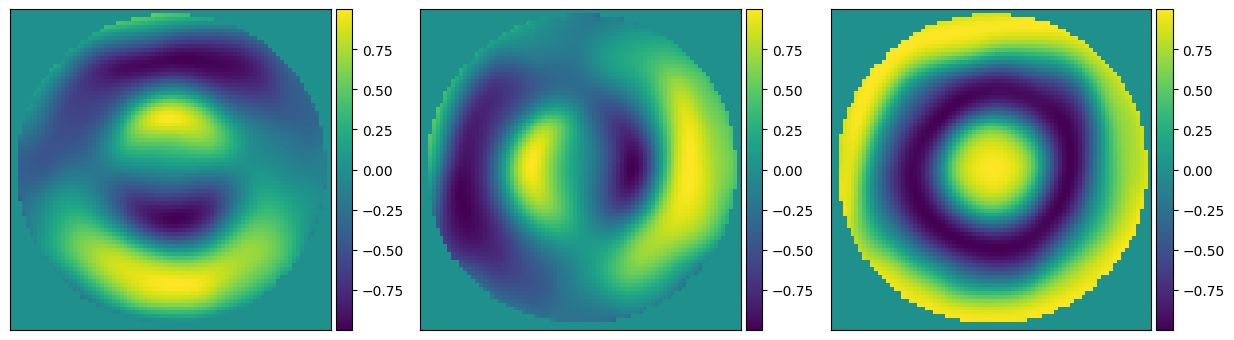

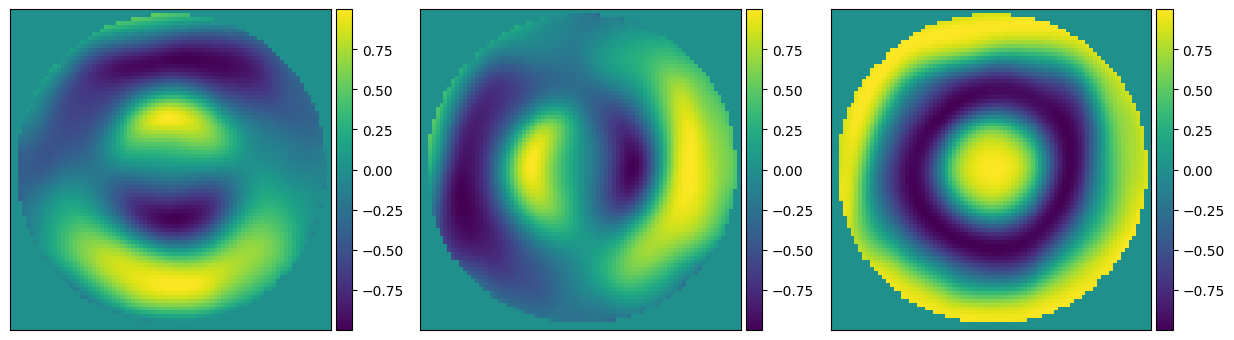

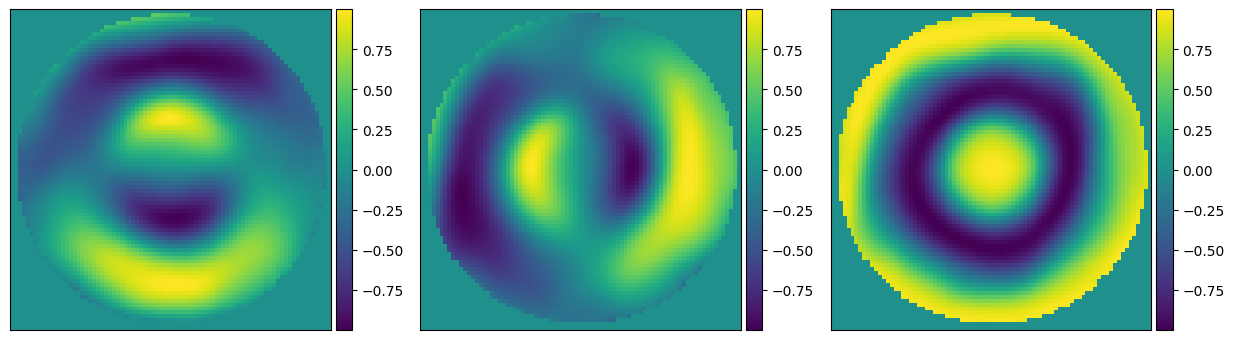

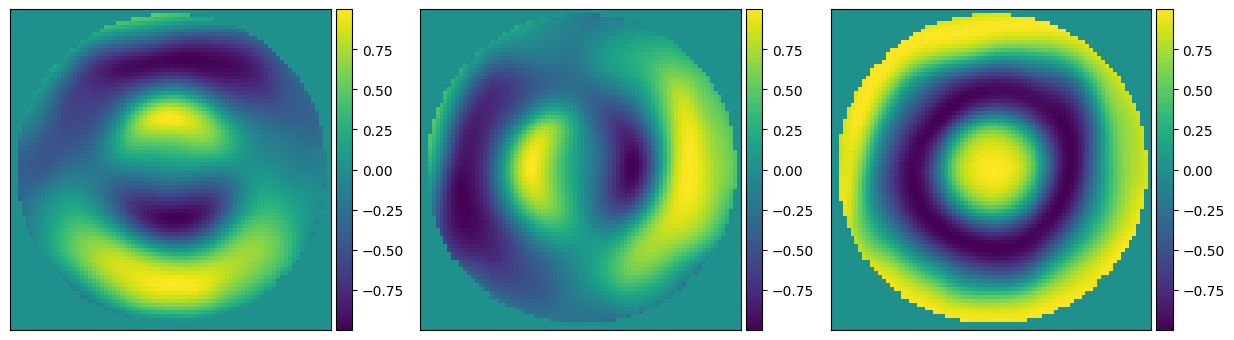

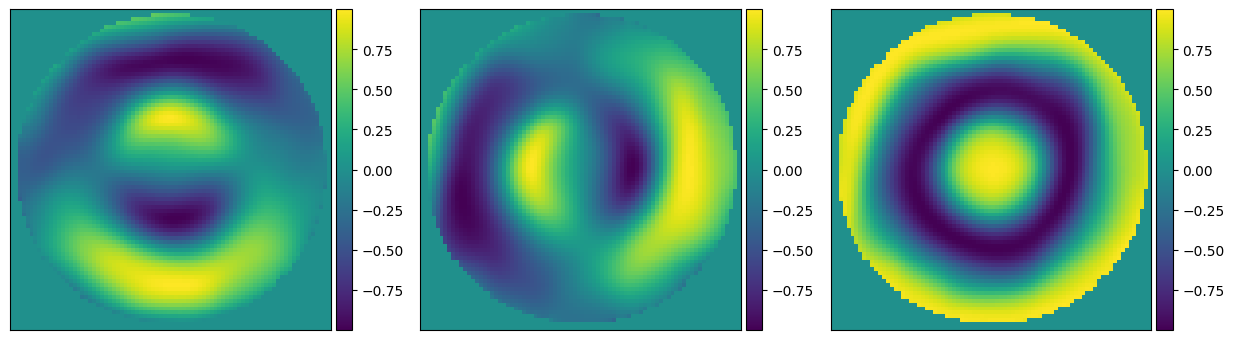

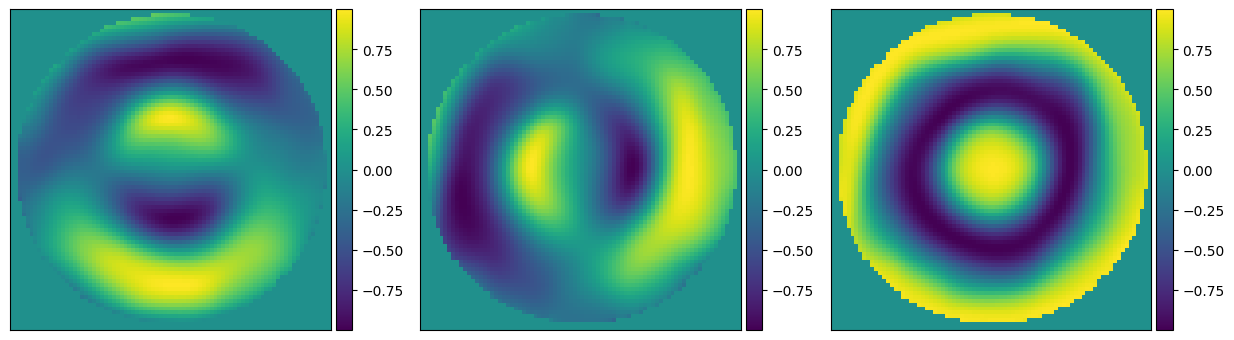

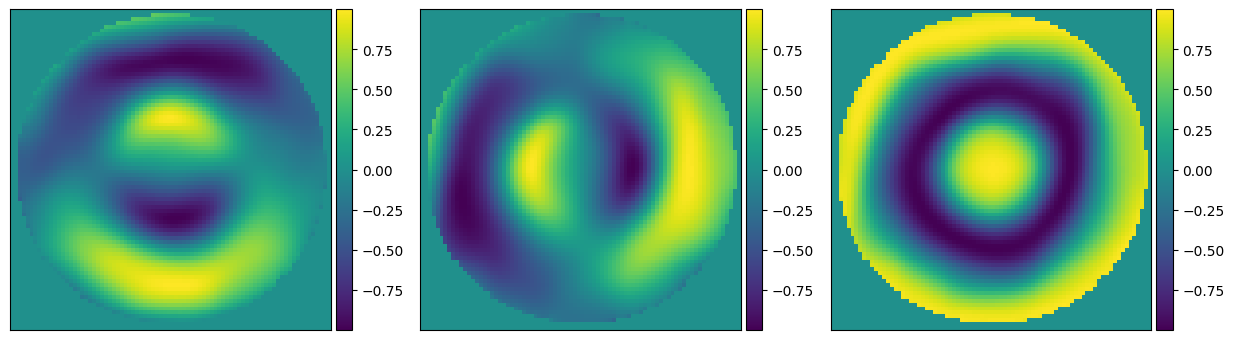

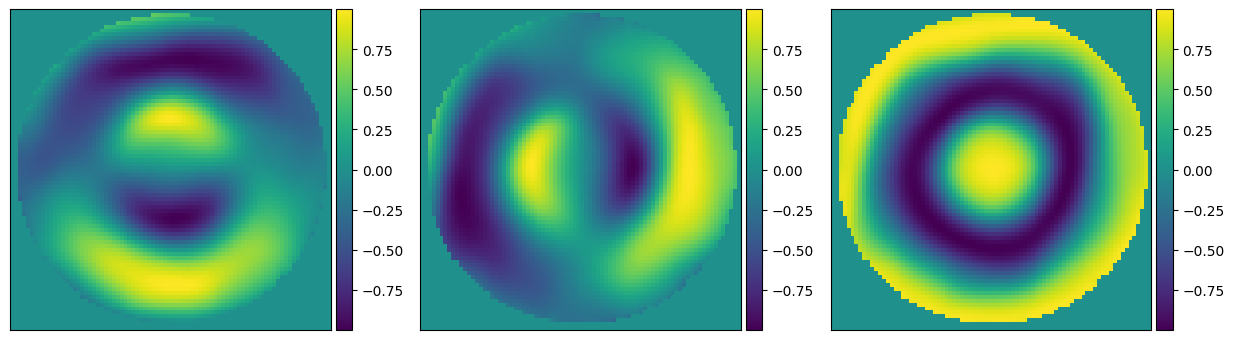

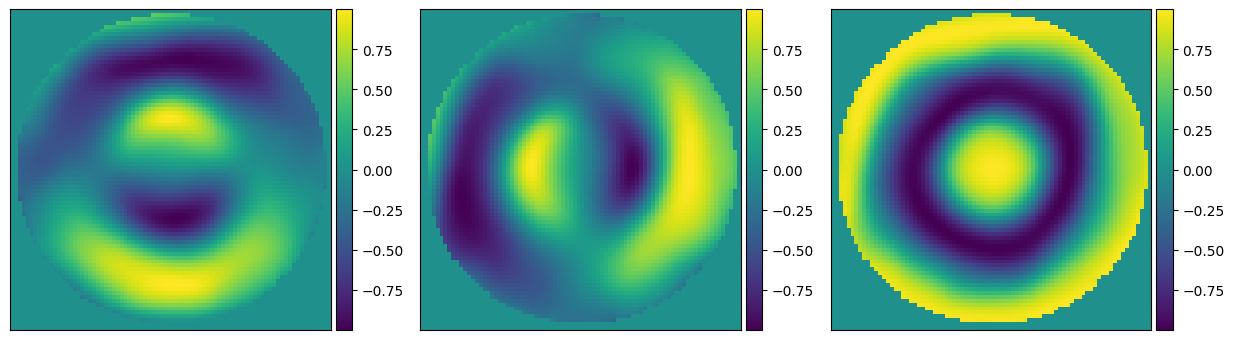

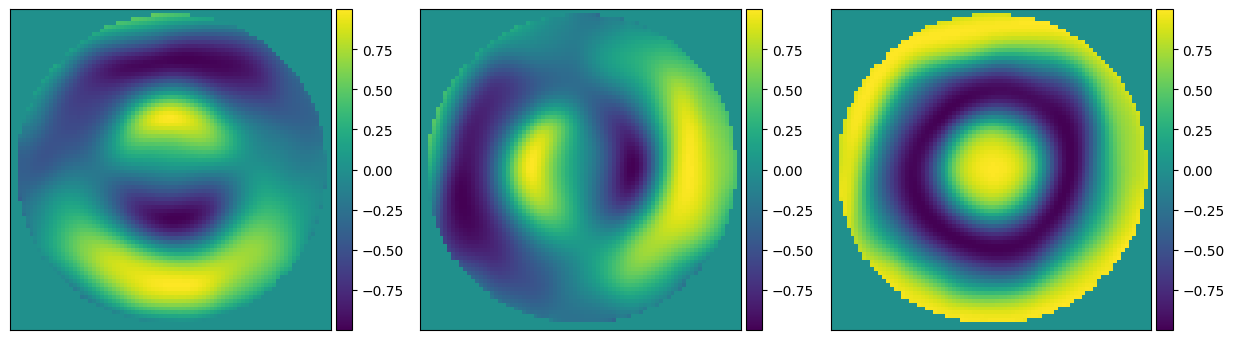

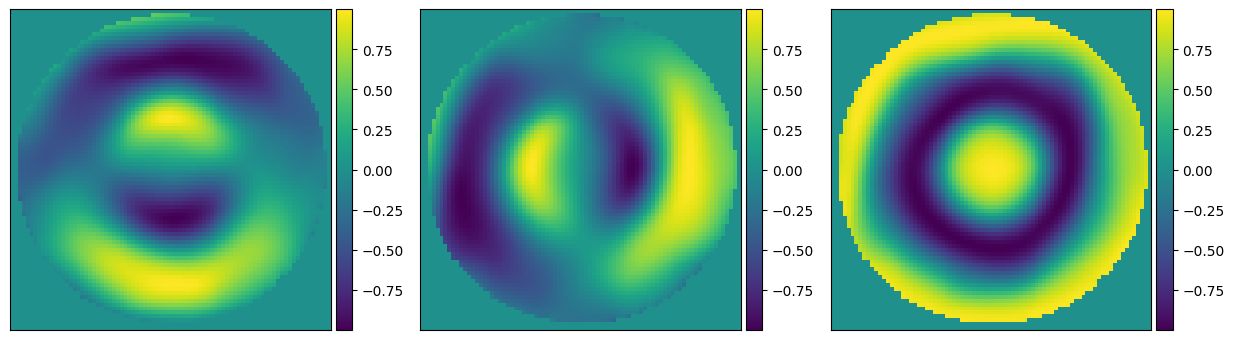

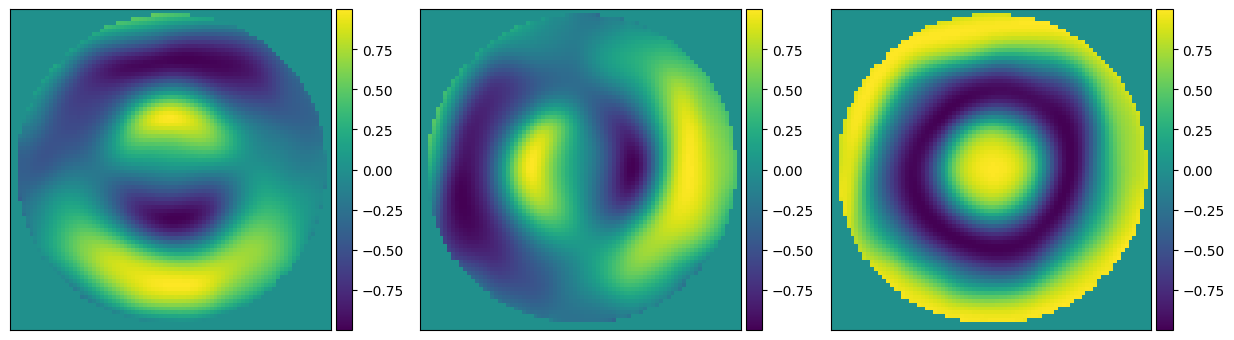

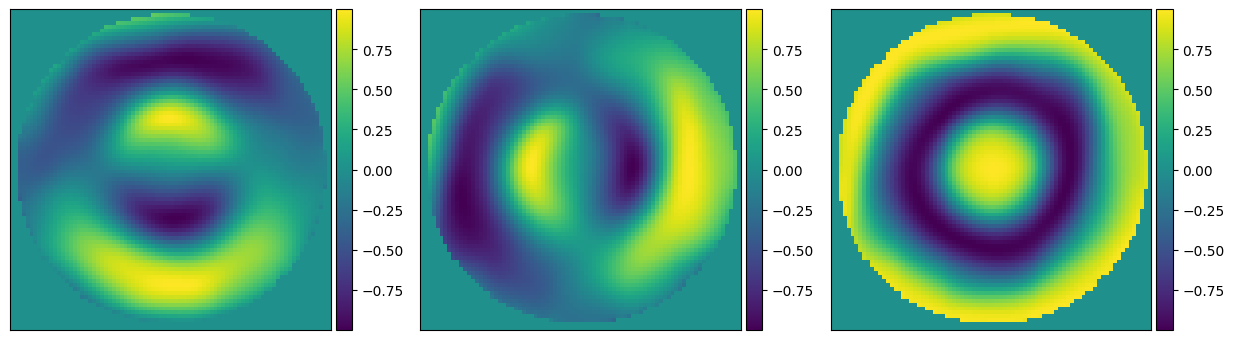

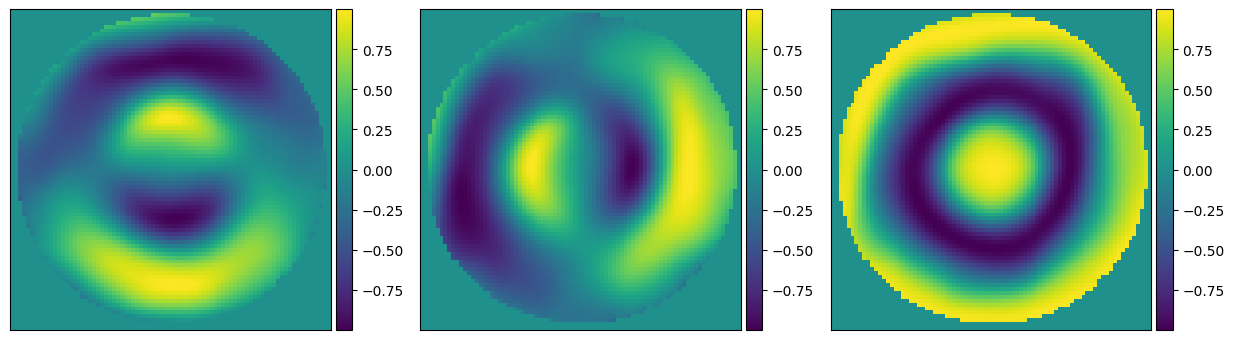

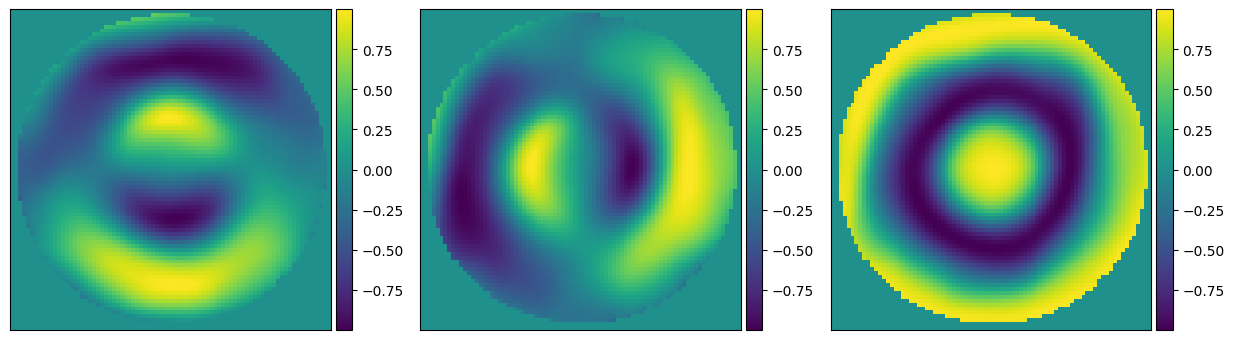

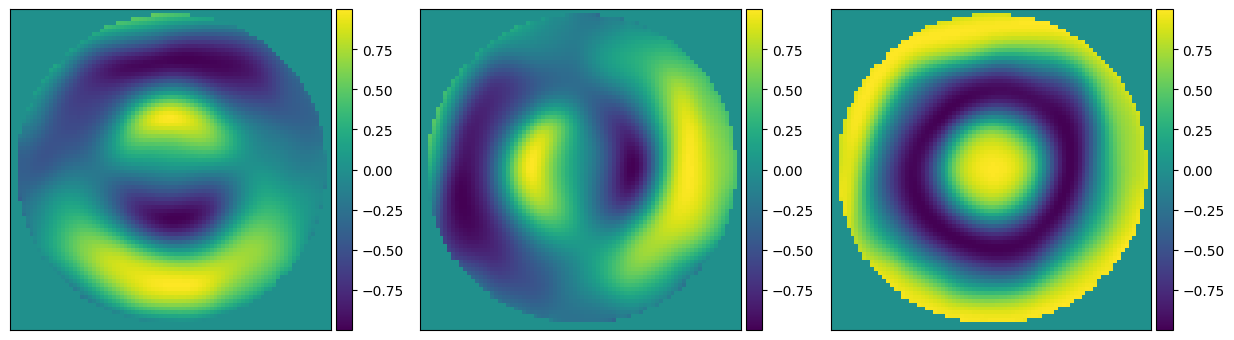

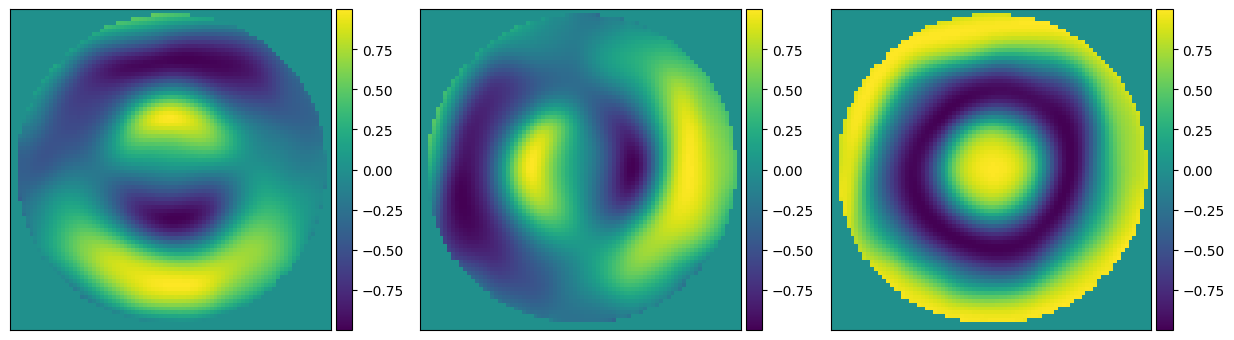

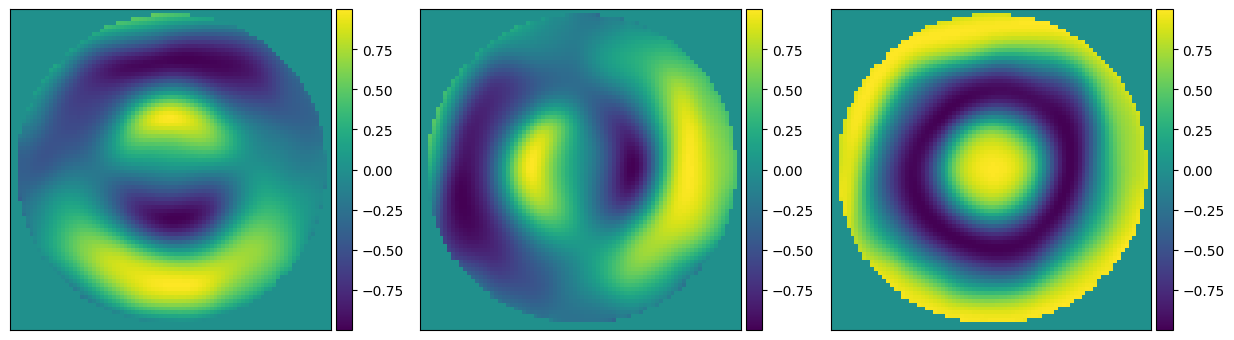

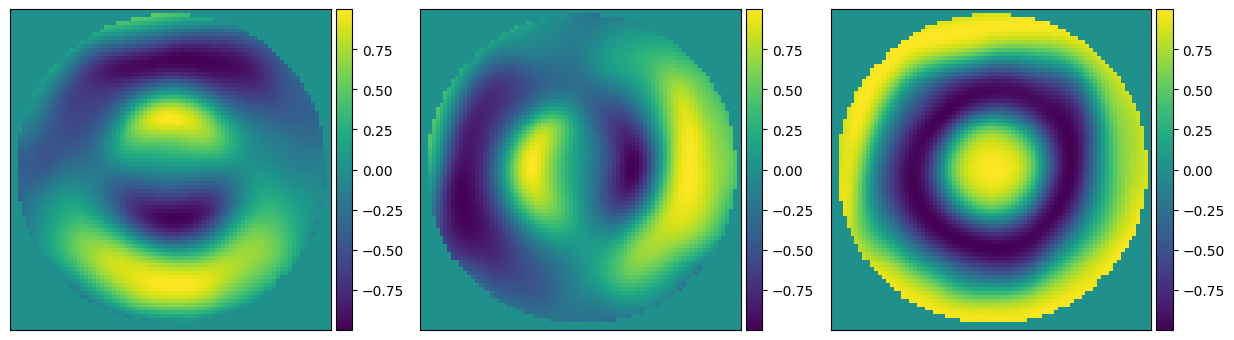

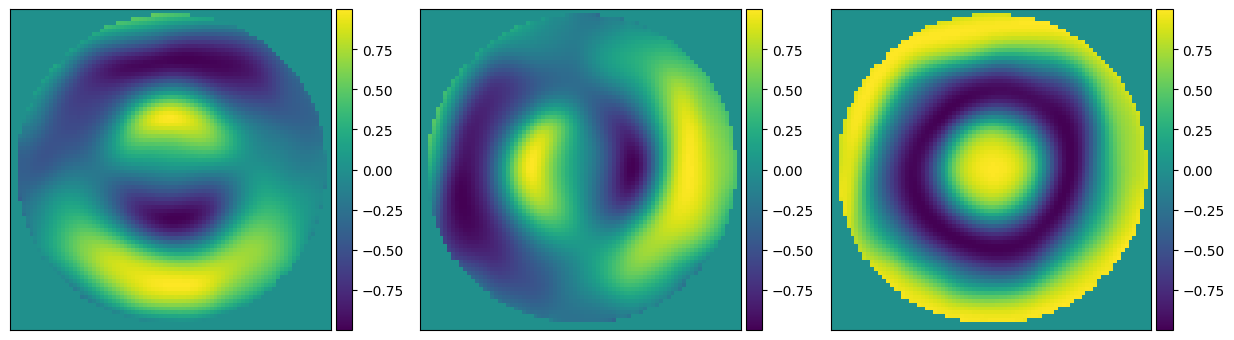

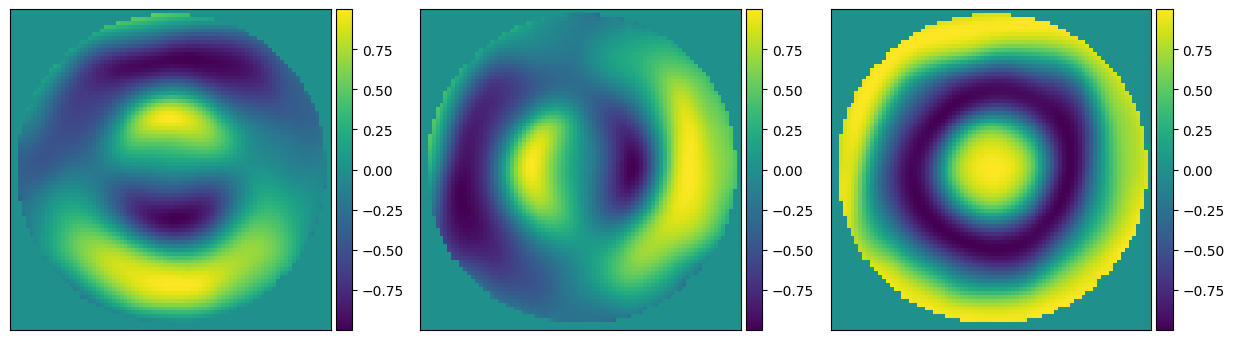

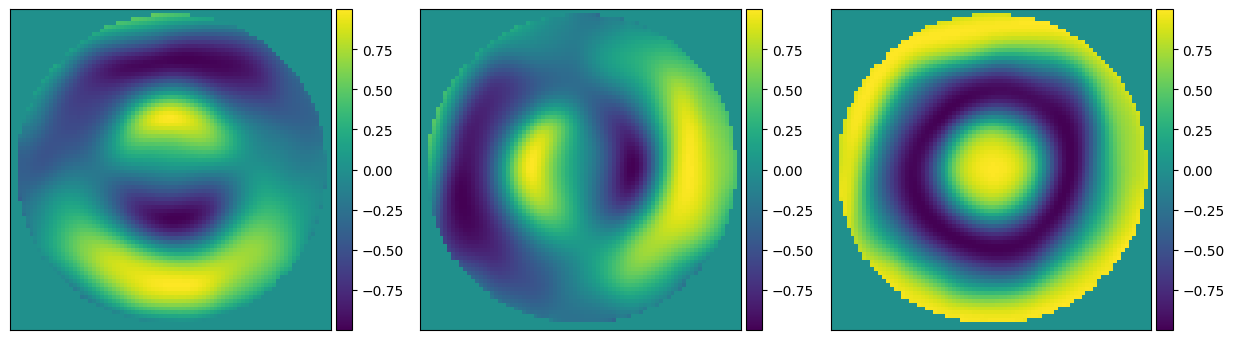

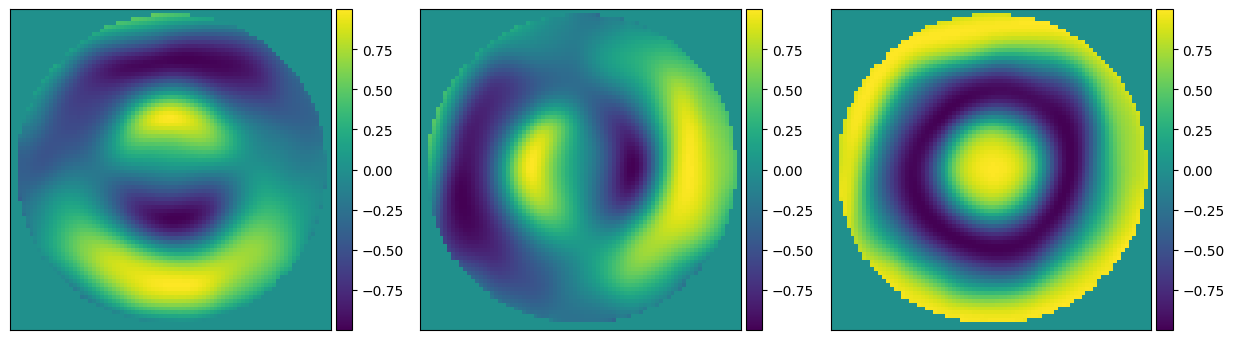

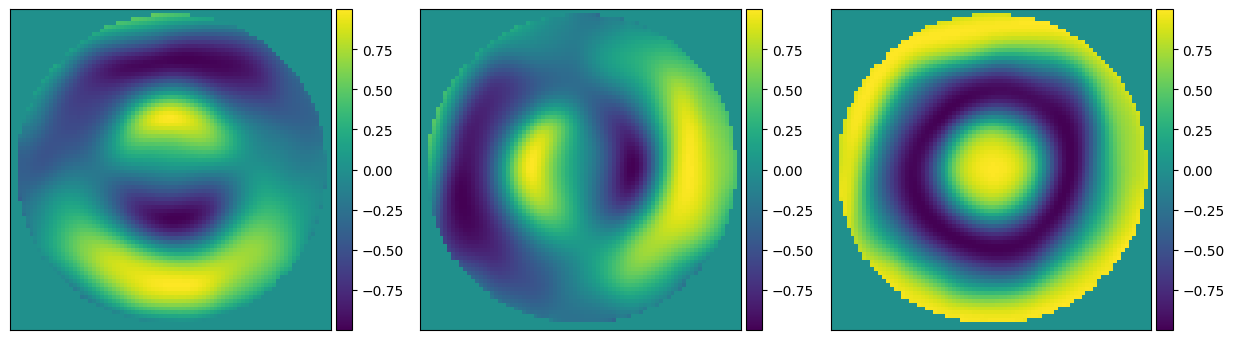

In [132]:
weight_phi = 3e7
for epoch in range(1000):
    spin = micro.get_spin()
    H = micro.get_total_field(spin)
    
    phi_pred = torch.stack([phasemapper(spin, *Eulers[i], Ms=Ms) for i in range(8)])
    diff = phi_input - phi_pred
    # Remove low-f background, and apply mask on the phasemap
    blurred = F.conv2d(diff, kernel_groups, groups=8, padding=gauss_kernel_size // 2)
    diff = (diff - blurred) * mask

    phi_loss = 0.
    for i in range(8):
        if i ==6 or i ==7:
            # apply 3x weight on low-tilt-angle phase
            phi_loss += 3 * weight_phi * torch.sum(diff[i,]**2)
        else:
            phi_loss += weight_phi * torch.sum(diff[i,]**2)
            
    H_from_phi = micro.get_field_from_loss(phi_loss, spin)
    H_total = H + H_from_phi
    new_spin = sd(spin, H_total)
    micro.update_spin(new_spin)
    if epoch % 100 == 0:
        print("epoch:", epoch)
        spin = micro.get_spin().detach().cpu().numpy()
        maglab.display.show_list([spin[i, :, :, nz//2] for i in range(3)])
        plt.savefig(f"pngs/epoch{epoch}.png",dpi=100)
        plt.close()

### 5.Compare predicted phase and the input phase

In [134]:
phase_pred_set = []
phase_diff_set = []
for i in range(8):
    Euler = phaseset[i].Euler
    phi_pred = phasemapper(spin, *Euler, Ms=Ms)
    diff = phaseset[i].data.cuda() - phi_pred
    diff_blurred = F.conv2d(diff.unsqueeze(0), kernel.repeat(1, 1, 1, 1).cuda(), groups=1, padding=gauss_kernel_size // 2)[0,]
    diff -= diff_blurred[0]
    phase_pred_set.append(phi_pred.detach().cpu().numpy())
    phase_diff_set.append(diff.detach().cpu().numpy())

(<Figure size 2000x1000 with 16 Axes>,
 array([[<Axes: title={'center': '(-65.0, 0.0, 0.0)'}>,
         <Axes: title={'center': '(-61.0, 0.0, 0.0)'}>,
         <Axes: title={'center': '(-58.0, 0.0, 0.0)'}>,
         <Axes: title={'center': '(-54.0, 0.0, 0.0)'}>],
        [<Axes: title={'center': '(-50.0, 0.0, 0.0)'}>,
         <Axes: title={'center': '(-44.0, 0.0, 0.0)'}>,
         <Axes: title={'center': '(-28.0, 0.0, 0.0)'}>,
         <Axes: title={'center': '(-0.0, 0.0, 0.0)'}>]], dtype=object))

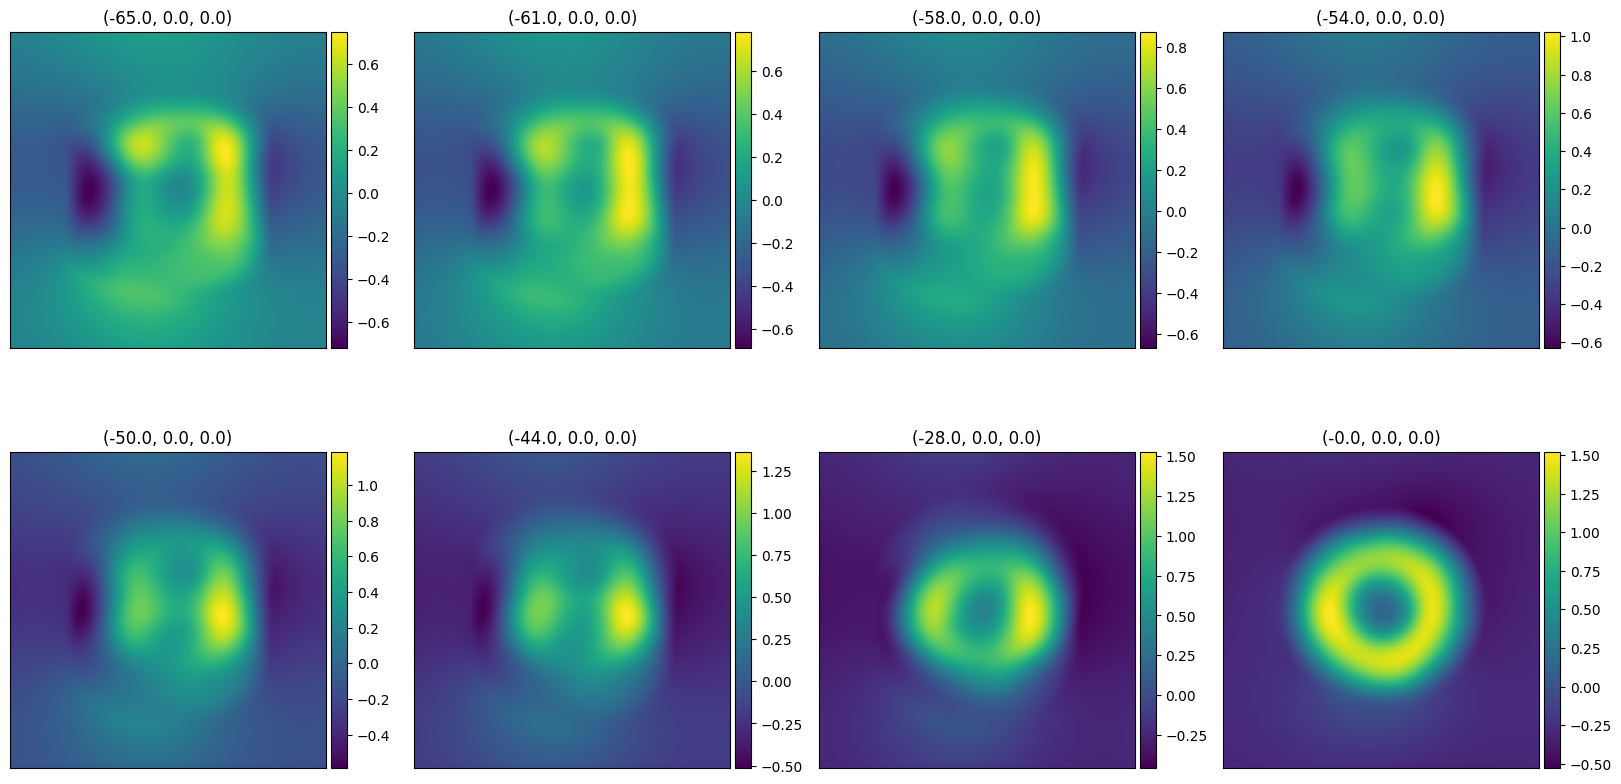

In [135]:
maglab.display.show_list(phase_pred_set, titles=[x.Euler for x in phaseset], 
                         same_colorbar=False,  rows=2,)

(<Figure size 2000x1000 with 16 Axes>,
 array([[<Axes: title={'center': '(-65.0, 0.0, 0.0)'}>,
         <Axes: title={'center': '(-61.0, 0.0, 0.0)'}>,
         <Axes: title={'center': '(-58.0, 0.0, 0.0)'}>,
         <Axes: title={'center': '(-54.0, 0.0, 0.0)'}>],
        [<Axes: title={'center': '(-50.0, 0.0, 0.0)'}>,
         <Axes: title={'center': '(-44.0, 0.0, 0.0)'}>,
         <Axes: title={'center': '(-28.0, 0.0, 0.0)'}>,
         <Axes: title={'center': '(-0.0, 0.0, 0.0)'}>]], dtype=object))

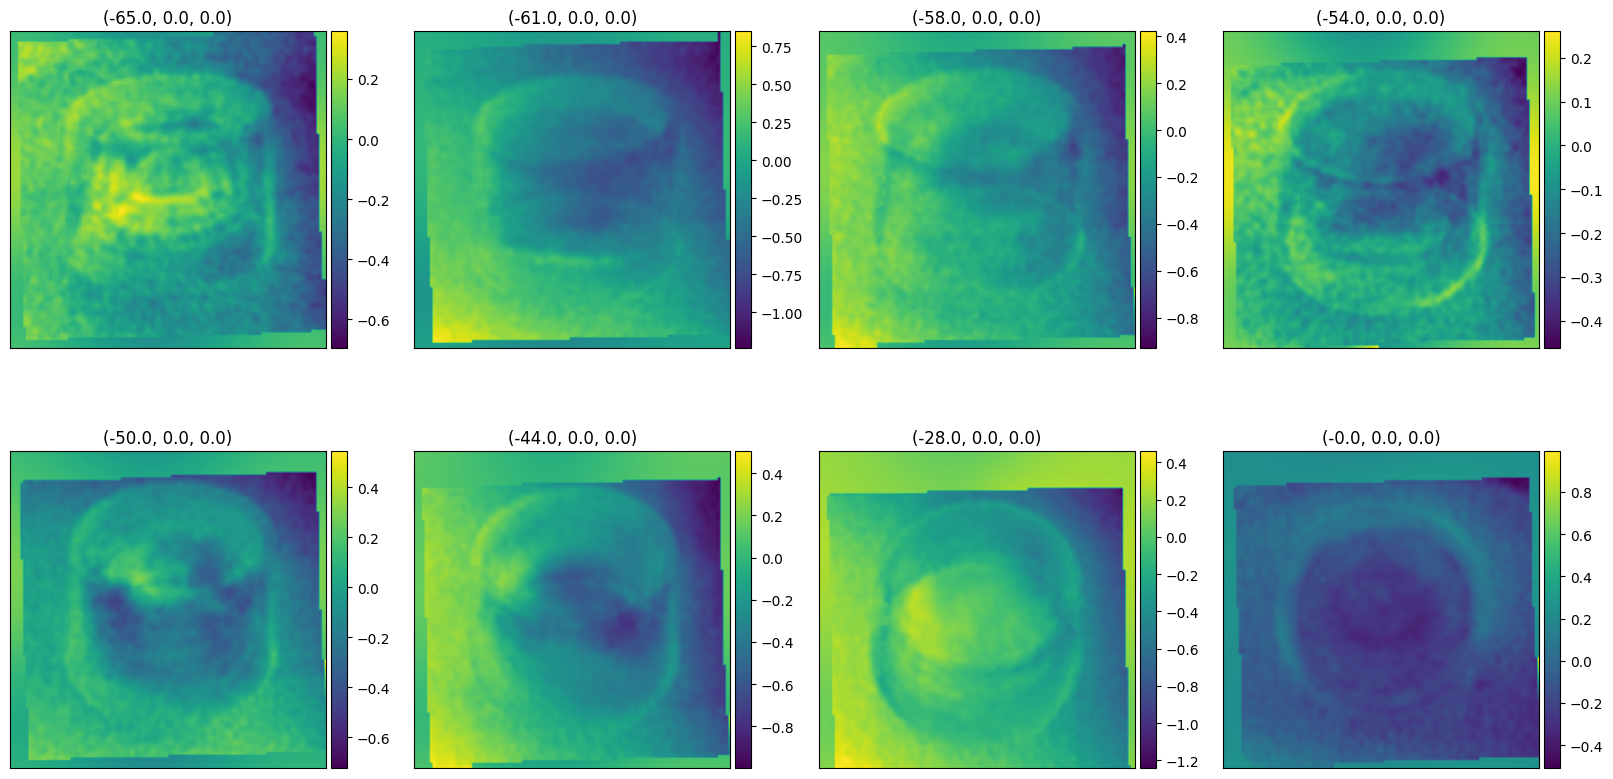

In [136]:
maglab.display.show_list(phase_diff_set, titles=[x.Euler for x in phaseset], 
                         same_colorbar=False,  rows=2,)

### 6.Save the magnetization as .vtk and use Paraview for visualization

In [115]:
spin = micro.get_spin().detach().cpu().numpy()
maglab.vtk.write_vtk("recon", spin, dx=dx)